In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
import datetime

# import categorical api 
from pandas.api.types import CategoricalDtype
from scipy.stats import chi2_contingency

#warnings.filterwarnings("ignore")

In [2]:
file = open('../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
data_cleaned = pd.read_csv(conf['local_data_path'] + "data_cleaned_final.csv",index_col=0,low_memory=False)

Influence de l'âge

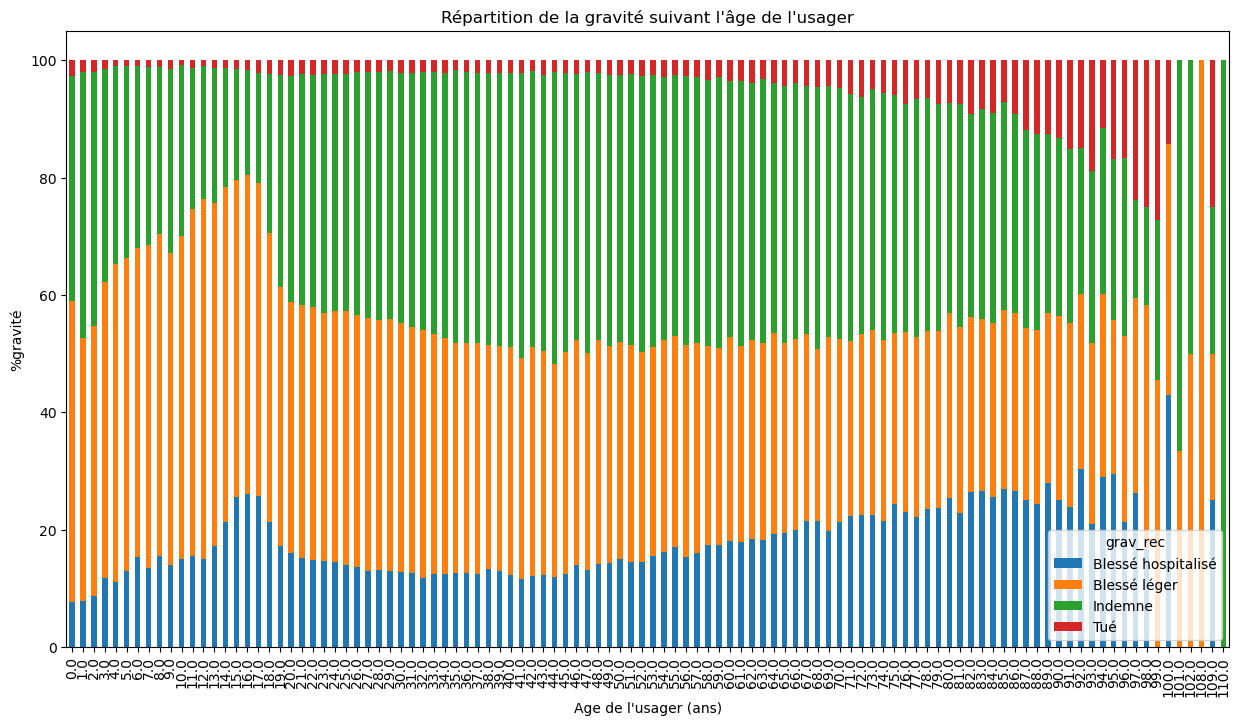

In [3]:
df_age = pd.crosstab(data_cleaned.age_usager,data_cleaned.grav_rec,normalize='index')*100
df_age.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title("Répartition de la gravité suivant l'âge de l'usager");
plt.ylabel('%gravité')
plt.xlabel("Age de l'usager (ans)")
plt.show()

In [4]:
labels_age = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69',
               '70-74', '75-79', '80-84', '85-89', '90-94', '95 et +']

In [6]:
age_cut = pd.cut(x = data_cleaned.age_usager, bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,150], labels = labels_age) 
data_cleaned['cat_age'] = age_cut

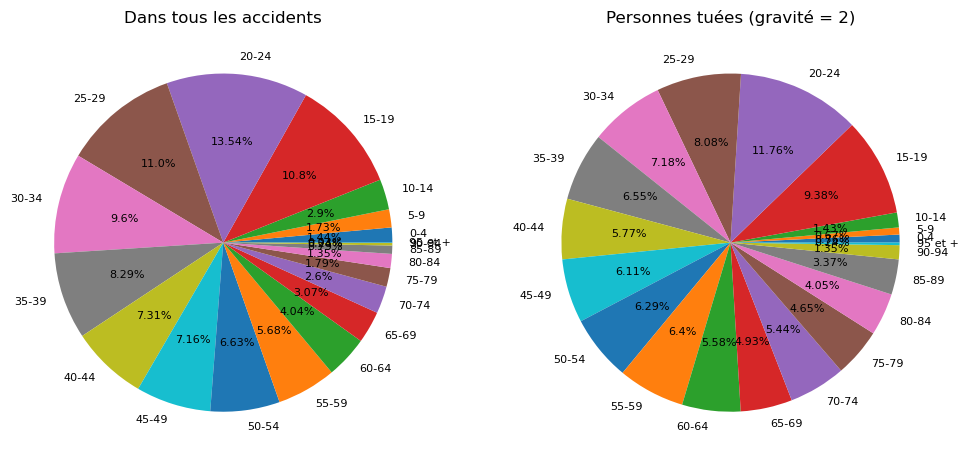

In [7]:
df_pietons = data_cleaned.loc[data_cleaned['place_rec_4.0'] == 1,:]
df2 = df_pietons.groupby([ 'grav', 'cat_age']).size()

plt.figure(figsize = (12, 10));
plt.subplot(121);
plt.title("Dans tous les accidents", fontsize=12);
plt.pie(data_cleaned.groupby(['cat_age']).size(), labels =  labels_age, labeldistance = 1.1,
       autopct=lambda x:str(round(x, 2))+'%', textprops={'fontsize':8});
plt.subplot(122);
plt.title("Personnes tuées (gravité = 2)", fontsize=12);
plt.pie(data_cleaned[data_cleaned.grav==2].groupby(['cat_age']).size().values, labels = labels_age , labeldistance = 1.1,
        autopct=lambda x:str(round(x, 2))+'%', textprops={'fontsize':8});


In [8]:
ct = pd.crosstab(data_cleaned.cat_age, data_cleaned.grav_rec)
ct

grav_rec,Blessé hospitalisé,Blessé léger,Indemne,Tué
cat_age,,,,
0-4,681,3217,2428,93
5-9,1126,4186,2326,82
10-14,2601,7431,2754,174
15-19,9597,22783,14680,1143
20-24,8843,25966,24208,1433
25-29,6412,21030,20659,984
30-34,5292,17551,19155,874
35-39,4690,14368,17153,798
40-44,3918,12330,15663,703


In [9]:
ct.mean()

grav_rec
Blessé hospitalisé    3497.10
Blessé léger          9000.20
Indemne               9213.00
Tué                    609.05
dtype: float64

Influence du sexe

In [10]:
pd.crosstab(data_cleaned.sexe, data_cleaned.grav_rec)

grav_rec,Blessé hospitalisé,Blessé léger,Indemne,Tué
sexe,,,,
0.0,49802,114044,132248,9556
1.0,20197,66344,52300,2645


In [11]:
df_age = data_cleaned.groupby(['sexe', 'grav', 'cat_age']).size().reset_index()
df_hommes = df_age[(df_age.sexe==0)]
df_femmes = df_age[(df_age.sexe==1)]
df_hommes_tues = df_age[(df_age.sexe==0) & (df_age.grav==2)]
df_femmes_tuees = df_age[(df_age.sexe==1) & (df_age.grav==2)]
nb_tues = df_hommes_tues[0].sum() + df_femmes_tuees[0].sum()

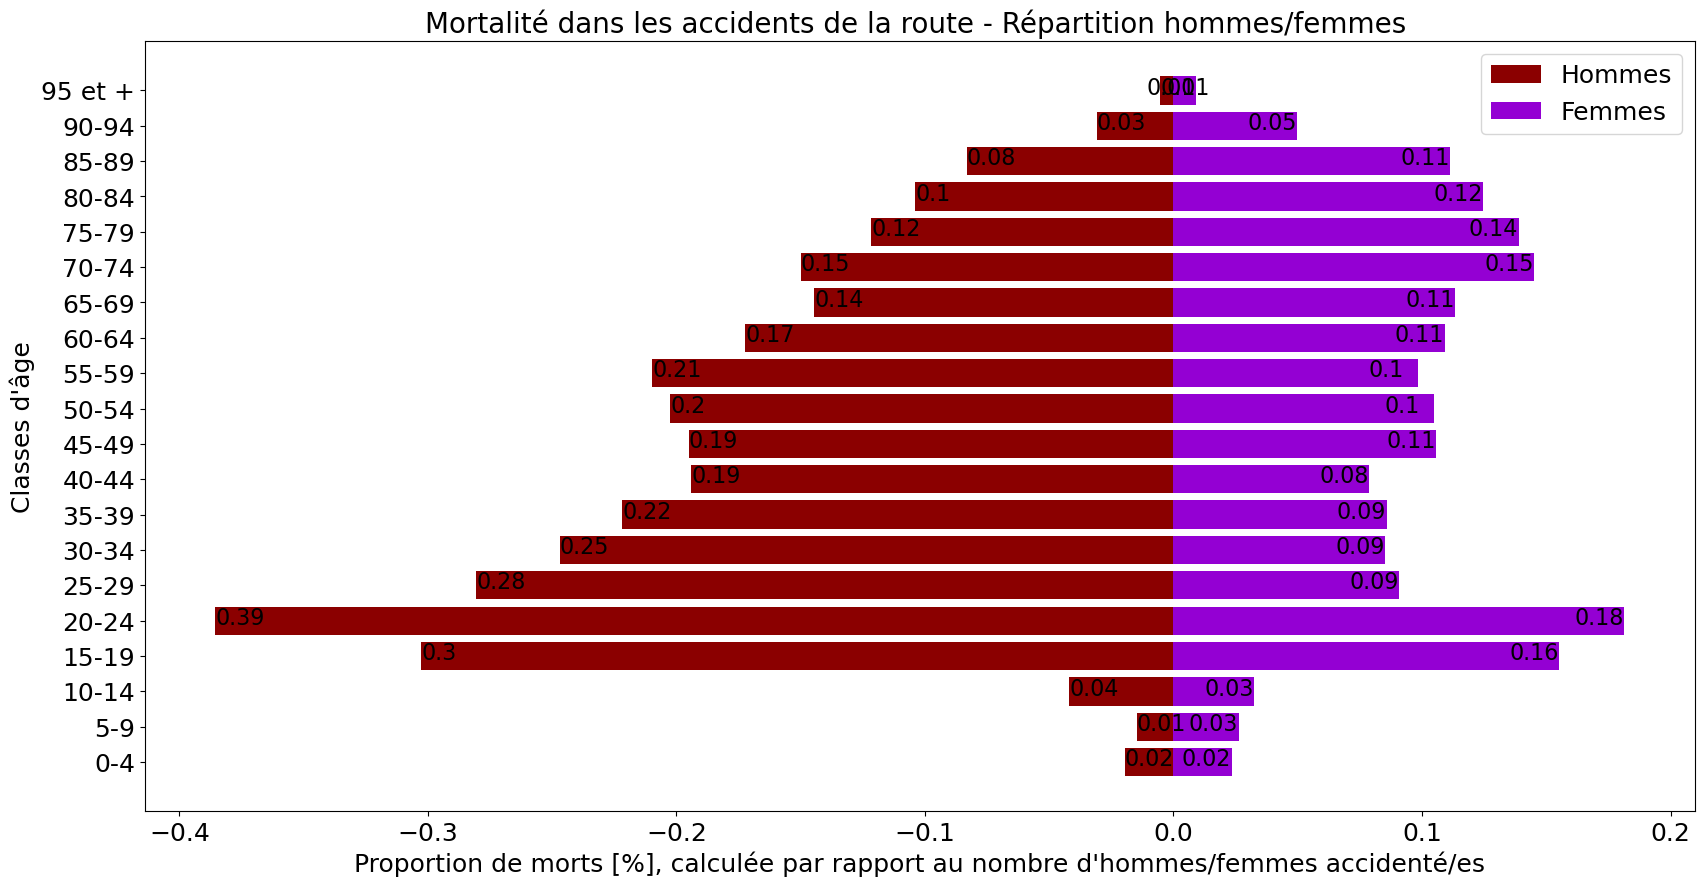

In [12]:
parameters = {"axes.labelsize": 20, "axes.titlesize": 20, "xtick.labelsize" : 18, "ytick.labelsize": 18,
             "legend.fontsize": 18}
plt.rcParams.update(parameters)

# Création du graphique.
fig, ax = plt.subplots(figsize=(20, 10))

# Affichage des données pour les hommes et les femmes.
ax.barh(df_hommes_tues.cat_age, -df_hommes_tues[0]/df_hommes[0].sum()*100, label="Hommes", color="darkred")
ax.barh(df_femmes_tuees.cat_age, df_femmes_tuees[0]/df_femmes[0].sum()*100, label="Femmes", color="darkviolet")

# Ajout des valeurs numériques sur le graphique.
for i, (homme, femme) in enumerate(zip(df_hommes_tues[0]/df_hommes[0].sum()*100, df_femmes_tuees[0]/df_femmes[0].sum()*100)):
    ax.text(-homme + 0.00, i - 0.1, f"{round(homme,2)}", color="black", fontsize=16)
    ax.text(femme - 0.02, i - 0.1, f"{round(femme,2)}" , color="black", fontsize=16)
    
ax.set_xlabel("Proportion de morts [%], calculée par rapport au nombre d'hommes/femmes accidenté/es", fontsize=18)
ax.set_ylabel("Classes d'âge", fontsize=18)
ax.set_title("Mortalité dans les accidents de la route - Répartition hommes/femmes ")
ax.legend()

# Affichage de la figure (surtout utile, si MPL est utilisé de manière standalone)
plt.show()

Lien âge et catégorie de véhicules

In [68]:
data_cleaned['catv'] = data_cleaned['catv_0.0']*0 + data_cleaned['catv_1.0']*1 + data_cleaned['catv_2.0']*2 + data_cleaned['catv_3.0']*3 + data_cleaned['catv_4.0']*4 + data_cleaned['catv_5.0']*5 
ct_age_catv = pd.crosstab(data_cleaned[data_cleaned.grav == 2.0].cat_age, data_cleaned[data_cleaned.grav == 2.0].catv, normalize='index')
ct_age_catv

catv,0,1,2,3,4,5
cat_age,,,,,,
0-4,0.892473,0.010753,0.043011,0.000000,0.043011,0.010753
5-9,0.841463,0.073171,0.000000,0.000000,0.085366,0.000000
10-14,0.505747,0.293103,0.028736,0.017241,0.155172,0.000000
15-19,0.672791,0.278215,0.011374,0.003500,0.032371,0.001750
20-24,0.659456,0.293789,0.014655,0.002094,0.028611,0.001396
25-29,0.603659,0.341463,0.017276,0.003049,0.034553,0.000000
30-34,0.559497,0.356979,0.029748,0.011442,0.037757,0.004577
35-39,0.577694,0.339599,0.042607,0.003759,0.036341,0.000000
40-44,0.536273,0.351351,0.038407,0.005690,0.066856,0.001422


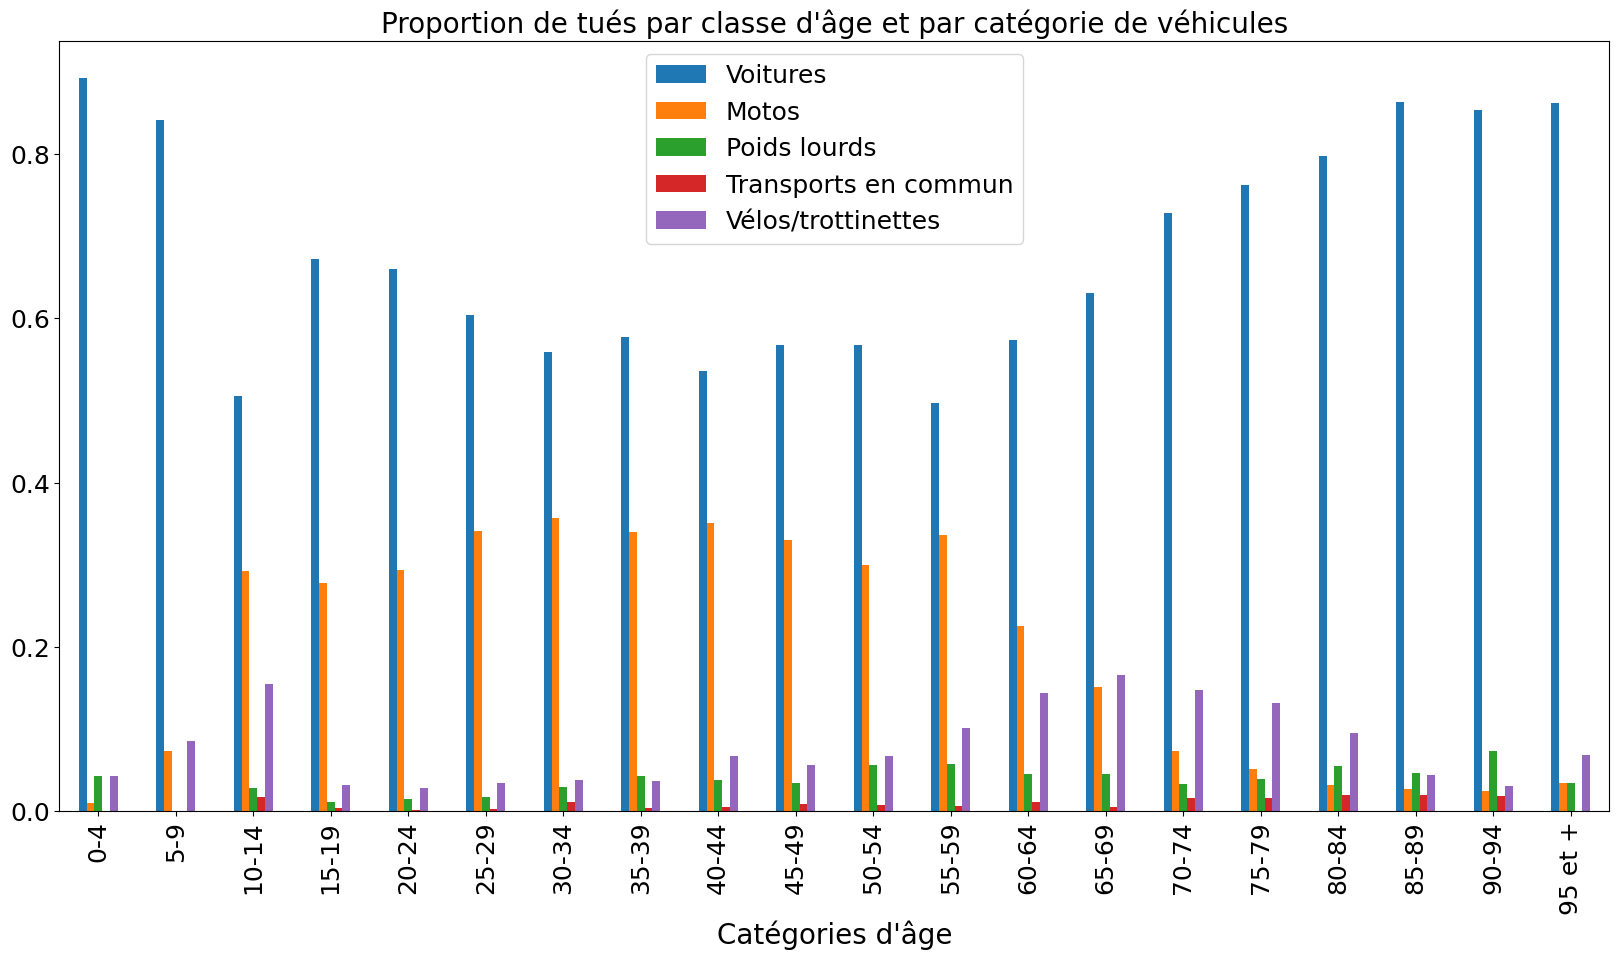

In [70]:
fig, ax = plt.subplots(figsize=(20, 10))
ct_age_catv.loc[:,:4].plot.bar(ax = ax)
ax.set_xlabel("Catégories d'âge")
plt.legend(['Voitures', 'Motos', 'Poids lourds', 'Transports en commun', 'Vélos/trottinettes']);
plt.title("Proportion de tués par classe d'âge et par catégorie de véhicules");
plt.show()

In [35]:
data_cleaned.columns[40:]

Index(['surf_1.0', 'surf_2.0', 'surf_3.0', 'surf_4.0', 'surf_5.0', 'surf_6.0',
       'surf_7.0', 'surf_8.0', 'surf_9.0', 'infra_0.0', 'infra_1.0',
       'infra_2.0', 'infra_3.0', 'infra_4.0', 'infra_5.0', 'infra_6.0',
       'infra_7.0', 'infra_8.0', 'infra_9.0', 'situ_1.0', 'situ_2.0',
       'situ_3.0', 'situ_4.0', 'situ_5.0', 'situ_6.0', 'situ_8.0',
       'place_rec_1.0', 'place_rec_2.0', 'place_rec_3.0', 'place_rec_4.0',
       'catv_0.0', 'catv_1.0', 'catv_2.0', 'catv_3.0', 'catv_4.0', 'catv_5.0',
       'obsm_0.0', 'obsm_1.0', 'obsm_2.0', 'obsm_3.0', 'manv_0.0', 'manv_1.0',
       'manv_2.0', 'manv_3.0', 'motor_0.0', 'motor_1.0', 'motor_2.0',
       'motor_3.0', 'motor_4.0', 'motor_5.0', 'motor_6.0', 'col_1.0',
       'col_2.0', 'col_3.0', 'col_4.0', 'col_5.0', 'col_6.0', 'col_7.0',
       'cat_age', 'catv', 'place_rec'],
      dtype='object')

In [56]:
pd.crosstab(data_cleaned.catv, data_cleaned['motor_1.0'])

motor_1.0,0,1
catv,,
0,31698,286588
1,6952,75172
2,1169,11495
3,1938,4479
4,25743,27
5,948,927


Places occupées par les hommes et les femmes impliqués dans des accidents de la route

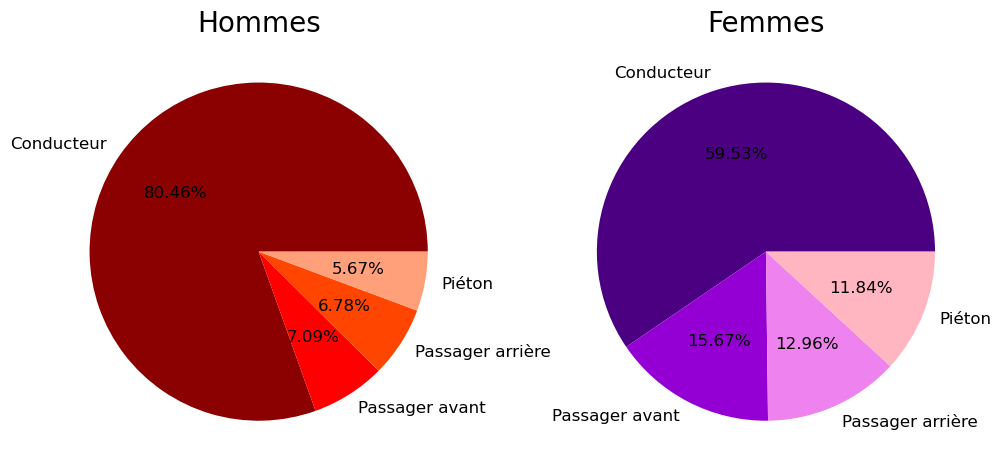

In [15]:
data_cleaned['place_rec'] = data_cleaned['place_rec_1.0']*0 + data_cleaned['place_rec_2.0']*1 + data_cleaned['place_rec_3.0']*2 + data_cleaned['place_rec_4.0']*3
sexe_catu = data_cleaned.groupby(['sexe', 'place_rec']).size().reset_index()
plt.figure(figsize = (12, 10));
plt.subplot(121);
plt.title("Hommes");
plt.pie(sexe_catu[0][0:4], labels =  ['Conducteur', 'Passager avant', 'Passager arrière', 'Piéton'], labeldistance = 1.1,
       autopct=lambda x:str(round(x, 2))+'%', colors=['darkred', 'red', 'orangered', 'lightsalmon'], textprops={'fontsize':12});
plt.subplot(122);
plt.title("Femmes");
plt.pie(sexe_catu[0][4:], labels =  ['Conducteur', 'Passager avant', 'Passager arrière', 'Piéton'], labeldistance = 1.1,
        autopct=lambda x:str(round(x, 2))+'%', colors=['indigo','darkviolet','violet', 'lightpink'], textprops={'fontsize':12});


In [16]:
ct_sexe_catv = pd.crosstab(data_cleaned.sexe, data_cleaned.catv, normalize='columns')

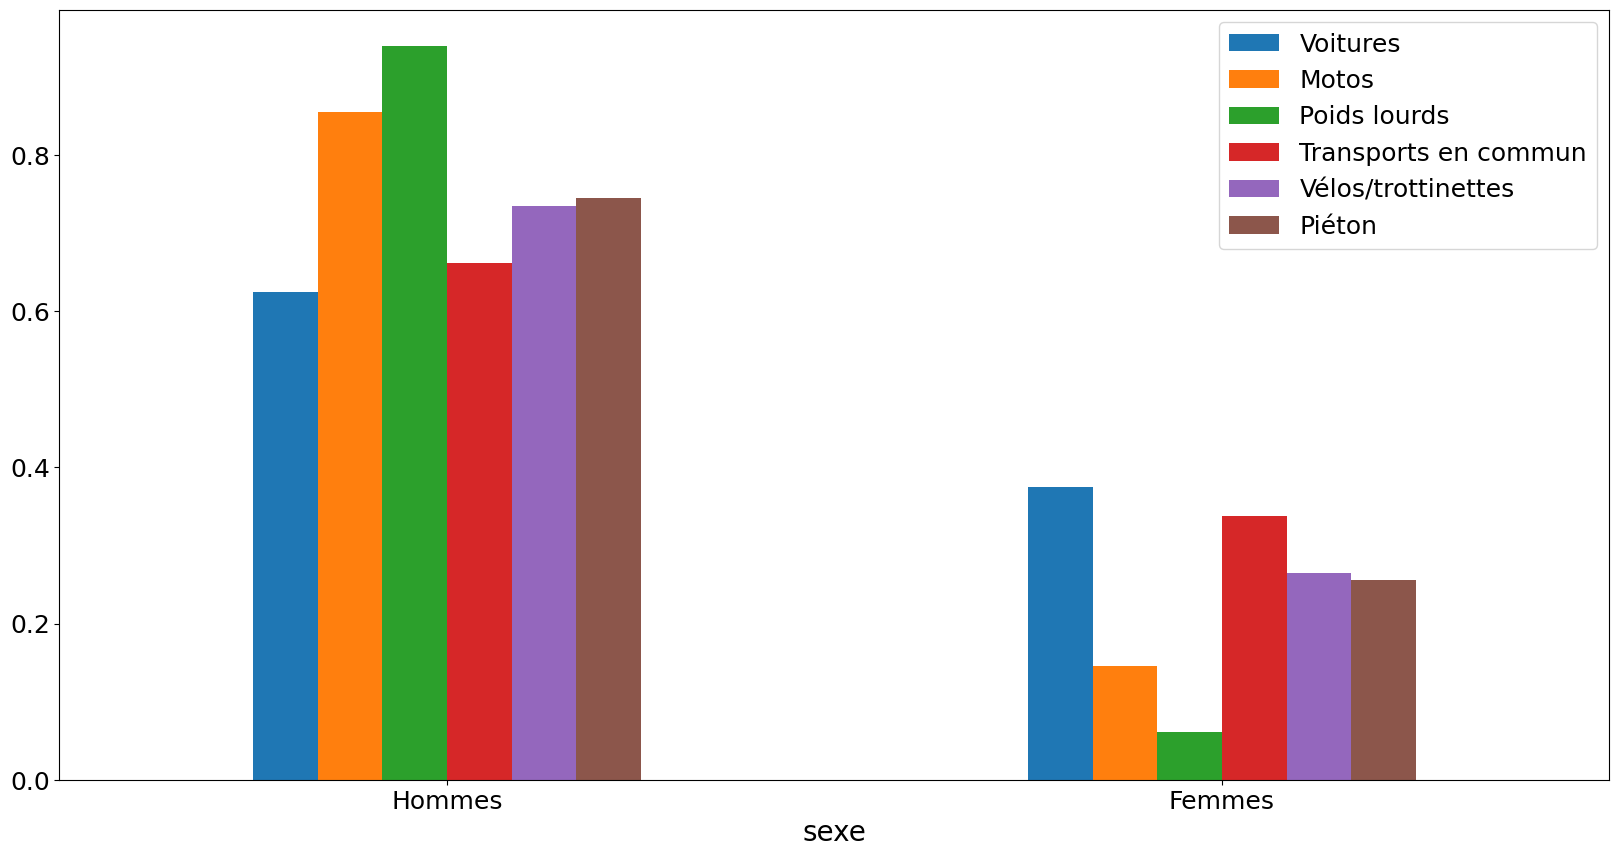

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
ct_sexe_catv.plot.bar(ax = ax)
ax.set_xticks([0.0, 1.0], ['Hommes', 'Femmes'], rotation=0)
plt.legend(['Voitures', 'Motos', 'Poids lourds', 'Transports en commun', 'Vélos/trottinettes','Piéton'])
plt.show()

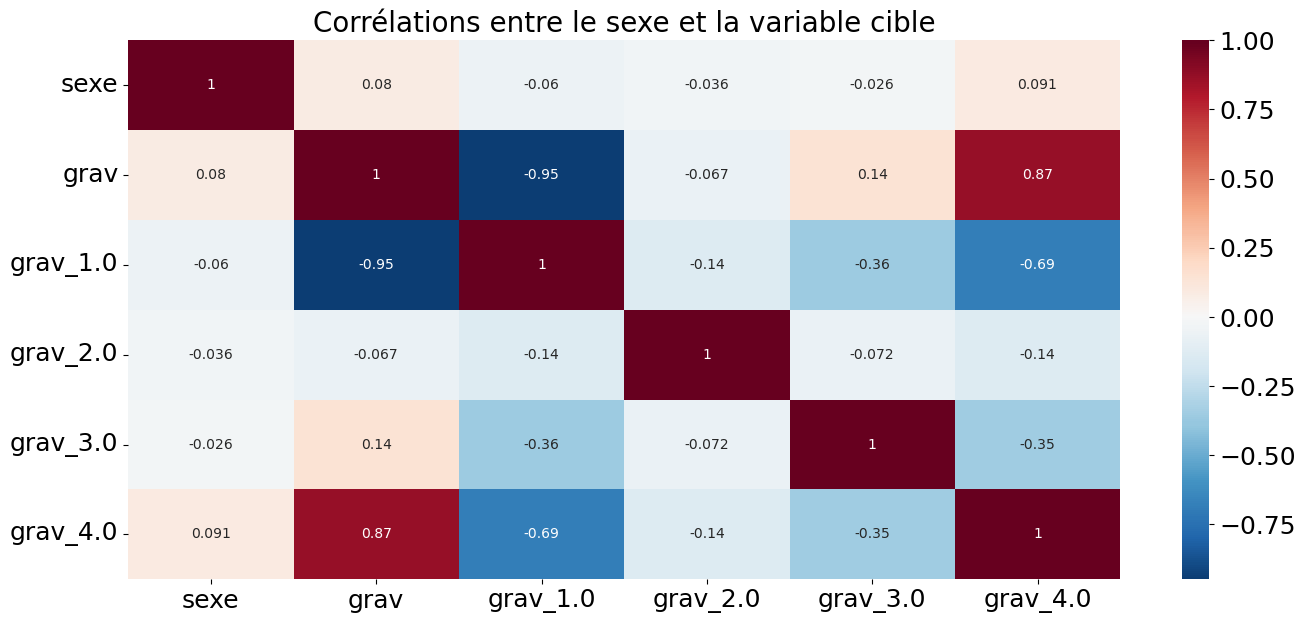

In [19]:
data_cleaned_dumm = data_cleaned.join(pd.get_dummies(data_cleaned.grav, prefix = 'grav'))

cols = data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('sexe')]
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('grav')])
cols = cols.drop('grav_rec')

correlation=data_cleaned_dumm.loc[:, cols].corr()
plt.figure(figsize=(16,7))
sns.heatmap(correlation,annot=True,center=0,cmap='RdBu_r');
plt.title('Corrélations entre le sexe et la variable cible');